# Data Analytics Programming Assignment 3

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import statsmodels.api as sm
from patsy import dmatrices
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<b>[Q1] Read in data</b>

In [2]:
# read in the gold file
gold = pd.read_csv('gold.txt',
                    sep = '\s+',
                    header = None,
                    names = ['url', 'category'])

# read in the labels file
labels = pd.read_csv('labels.txt',
                      sep = '\s+',
                      header = None,
                      names = ['turk', 'url', 'category'])

<b>[Q2] Split into two DataFrames</b>

In [3]:
# get a df with the matching url's from gold
labels_on_gold = labels[labels['url'].isin(gold['url'])]

# this has the url's not in gold
labels_unknown = labels[~labels['url'].isin(gold['url'])]

<b>[Q3] Compute accuracies of turks</b>

In [4]:
# set up a merge with same url's
rater_good = labels_on_gold.merge(gold, 
                                  left_on = 'url',
                                  right_on = 'url').set_index('turk')

# get the correctness
correctness = (rater_good[rater_good['category_x'] == rater_good['category_y']].groupby('turk')['url'].count() / rater_good.groupby('turk')['url'].count()).fillna(0)

# get the total ratings count
total_ratings = rater_good.groupby('turk')['url'].count()

# put these two series into one data frame
rater_goodness = pd.concat([total_ratings, correctness], axis=1)
rater_goodness.columns=['total_ratings', 'correctness']

<b>[Q4] Odds ratios</b>

In [5]:
def odds(p):
    """This function computes the odds of success given fraction p"""
    return p / (1.001 - p)

# map the odds function from the correctness ratings
rater_goodness['odds'] = rater_goodness['correctness'].map(odds)

<b>[Q5] Most accurate turks</b>

In [6]:
# get the most accurate turks, by correctness ratings, applying a mask for those rating at least 20 url's
top10_turks = rater_goodness[rater_goodness['total_ratings'] >= 20].sort_values(by='correctness', ascending=False)[:10]
top10_turks

,total_ratings,correctness,odds
turk,,,
A2U0R4X38GUKZE,20,0.950000,18.627451
A22C0PJUBFJTI0,36,0.916667,10.869565
A23YQUBXZPKILZ,24,0.875000,6.944444
ATVALOQVDCMZW,103,0.854369,5.826657
A1HIXWH4OXT8S4,40,0.825000,4.687500
A3220HG1O83HQ4,22,0.818182,4.475385
A32W20KGQXS0LL,25,0.800000,3.980100
A20PWAB7G3HDHU,20,0.800000,3.980100
AJSJVK40F5HM6,28,0.785714,3.649635


<b>[Q6] Rating counts versus accuracy</b>

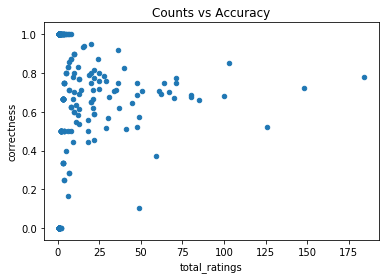

In [7]:
# plotting the counts versus accuracy
rater_goodness.sort_values(by='correctness', ascending=False).plot.scatter('total_ratings', 
                                                                           'correctness', 
                                                                           title='Counts vs Accuracy')

Based on this scatter plot, there seems to be no linear relationship between ratings count and the accuracy of a turk, in fact there is more of a distribution of accuracies, and having more ratings does not mean a turk will have higher accuracy. I will run a simple linear regression to further explore this relationship:

In [8]:
# create the design matrices
y, X = dmatrices('correctness ~ total_ratings', data=rater_goodness, return_type='dataframe')

# set up the model
model = sm.OLS(y, X)      

# fit the model and print the summary statistics
result = model.fit()       
print result.summary()

                            OLS Regression Results                            
Dep. Variable:            correctness   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5488
Date:                Wed, 08 Aug 2018   Prob (F-statistic):              0.459
Time:                        15:30:27   Log-Likelihood:                -94.663
No. Observations:                 269   AIC:                             193.3
Df Residuals:                     267   BIC:                             200.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.6431      0.024     27.071

From this output it is easy to conclude that there is no relationship between ratings count and the average correctness of a turk. The R-squared values are extremely low, and p-values are high, indicating there is no statistical significance between these variables, and thus the variables are not related.

<b>[Q7] Overall predicted odds</b>

In [9]:
# get the cutoff for these turks who rated more than 75% of all turks
rater_goodness.quantile(0.75)

total_ratings      11.0
correctness         1.0
odds             1000.0
Name: 0.75, dtype: float64

So we will consider all turks who rated more than 11 URLs.

In [10]:
# get the turks who rated more than 11 url's, or the top 25% of turks by total ratings
top25 = rater_goodness[rater_goodness['total_ratings'] > 11.0]

# set up new data frame with (u,c) pair from url's not in gold set, with just the selected turks
predicted = labels_unknown.merge(top25, 
                                 left_on='turk',
                                 right_on='turk').set_index('turk')

# put their odds in a new overall odds column
predicted['overall_odds'] = top25['odds']

# get the products of odds
products = predicted.groupby(['url', 'category'])['overall_odds'].prod()
products[:10]

url                                                       category
http://0-101.net                                          G            2.155963
http://000.cc                                             G            1.460583
http://0000.jp                                            G           14.488244
http://000relationships.com                               G            5.681060
                                                          P            1.851852
http://000vitamins.com                                    G            3.784982
http://000webhost.com                                     G           11.159502
http://003my.com                                          G            4.912040
http://007absolutehardcore.com/early_cumshots/index.html  P            3.346522
                                                          R           12.290450
Name: overall_odds, dtype: float64

<b>[Q8] Predicted categories</b>

In [11]:
# unstack to get the products of odds by category
by_cat = products.unstack('category').fillna(0)

# get top odds for each category
by_cat['top_odds'] = by_cat.max(axis=1)

# get the category for these top odds
by_cat['top_category'] = by_cat.idxmax(axis=1)

# get the predictions data frame
result_75 = pd.concat([by_cat['top_category'], by_cat['top_odds']], axis=1)
result_75[:10]

,top_category,top_odds
url,,
http://0-101.net,G,2.155963
http://000.cc,G,1.460583
http://0000.jp,G,14.488244
http://000relationships.com,G,5.681060
http://000vitamins.com,G,3.784982
http://000webhost.com,G,11.159502
http://003my.com,G,4.912040
http://007absolutehardcore.com/early_cumshots/index.html,X,293.252871
http://007swz.cn,G,1.393883


<b>[Q9] Predicted categories using more
turks</b>

In [12]:
# get the cutoff for the top 75% of turks
rater_goodness.quantile(0.25)

total_ratings    1.000000
correctness      0.500000
odds             0.998004
Name: 0.25, dtype: float64

So now we will consider turks who rated more than 1 URL.

In [13]:
# take turks that rated more than 1 url, or the top 75% of turks by ratings count
top75 = rater_goodness[rater_goodness['total_ratings'] > 1.0]

# repeat the steps from Q7 for these turks now
predicted75 = labels_unknown.merge(top75, left_on='turk',
                    right_on='turk').set_index('turk')

predicted75['overall_odds'] = top75['odds']
products75 = predicted75.groupby(['url', 'category'])['overall_odds'].prod()

# repeat the steps from Q8 for these turks now
by_cat75 = products75.unstack('category').fillna(0)

by_cat75['top_odds'] = by_cat75.max(axis=1)
by_cat75['top_category'] = by_cat75.idxmax(axis=1)

# make the result_25 data frame
result_25 = pd.concat([by_cat75['top_odds'], by_cat75['top_category']], axis=1)

# merge these two data frames by url
merge = result_75.merge(result_25,
                  left_on = 'url',
                  right_on = 'url',
                  suffixes=['_75', '_25'])

# create a crosstab to compare the number of url's predicted for the categories
compare = pd.crosstab(merge['top_category_75'], merge['top_category_25'])
compare

top_category_25,G,P,R,X
top_category_75,,,,
G,8327,574,186,216
P,189,328,47,19
R,21,34,128,25
X,27,6,26,457


The most errors are where the category was predicted to be "G" by the top 25% turks (the "more reliable" turks), but predicted to be "P" by the top 75% turks, which includes the "less reliable" turks.